In [2]:
import polars as pl
import itertools
import io

n = 10
with open("arxiv-metadata-oai-snapshot.json") as f:
    sample = list(itertools.islice(f, n))

data_str = "".join(sample)
df = pl.read_ndjson(io.StringIO(data_str))

print(df.head())

shape: (5, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ id        ┆ submitter ┆ authors   ┆ title     ┆ … ┆ abstract  ┆ versions  ┆ update_da ┆ authors_ │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ te        ┆ parsed   │
│ str       ┆ str       ┆ str       ┆ str       ┆   ┆ str       ┆ list[stru ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ ct[2]]    ┆ str       ┆ list[lis │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ t[str]]  │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0704.0001 ┆ Pavel     ┆ C.        ┆ Calculati ┆ … ┆ A fully   ┆ [{"v1","M ┆ 2008-11-2 ┆ [["Baláz │
│           ┆ Nadolsky  ┆ Bal\'azs, ┆ on of     ┆   ┆ different ┆ on, 2 Apr ┆ 6         ┆ s",      │
│           ┆           ┆ E. L.     ┆ prompt    ┆   ┆ ial       ┆ 2007      

Processed 500,000 articles... Found 1 with 'Mistral'
Processed 1,000,000 articles... Found 2 with 'Mistral'
Processed 1,500,000 articles... Found 3 with 'Mistral'
Processed 2,000,000 articles... Found 60 with 'Mistral'
Processed 2,500,000 articles... Found 1043 with 'Mistral'

Total articles processed: 2,866,787
Articles containing 'Mistral': 1045

Analyzing word co-occurrences with 'Mistral'...

Top 20 words co-occurring with 'Mistral' (by TF-IDF score):
 1. llms                 (score: 0.0643)
 2. models               (score: 0.0625)
 3. model                (score: 0.0437)
 4. language             (score: 0.0406)
 5. data                 (score: 0.0383)
 6. performance          (score: 0.0364)
 7. fine                 (score: 0.0338)
 8. llm                  (score: 0.0329)
 9. 7b                   (score: 0.0326)
10. reasoning            (score: 0.0317)
11. large                (score: 0.0310)
12. tasks                (score: 0.0303)
13. gpt                  (score: 0.0278)
14. tra

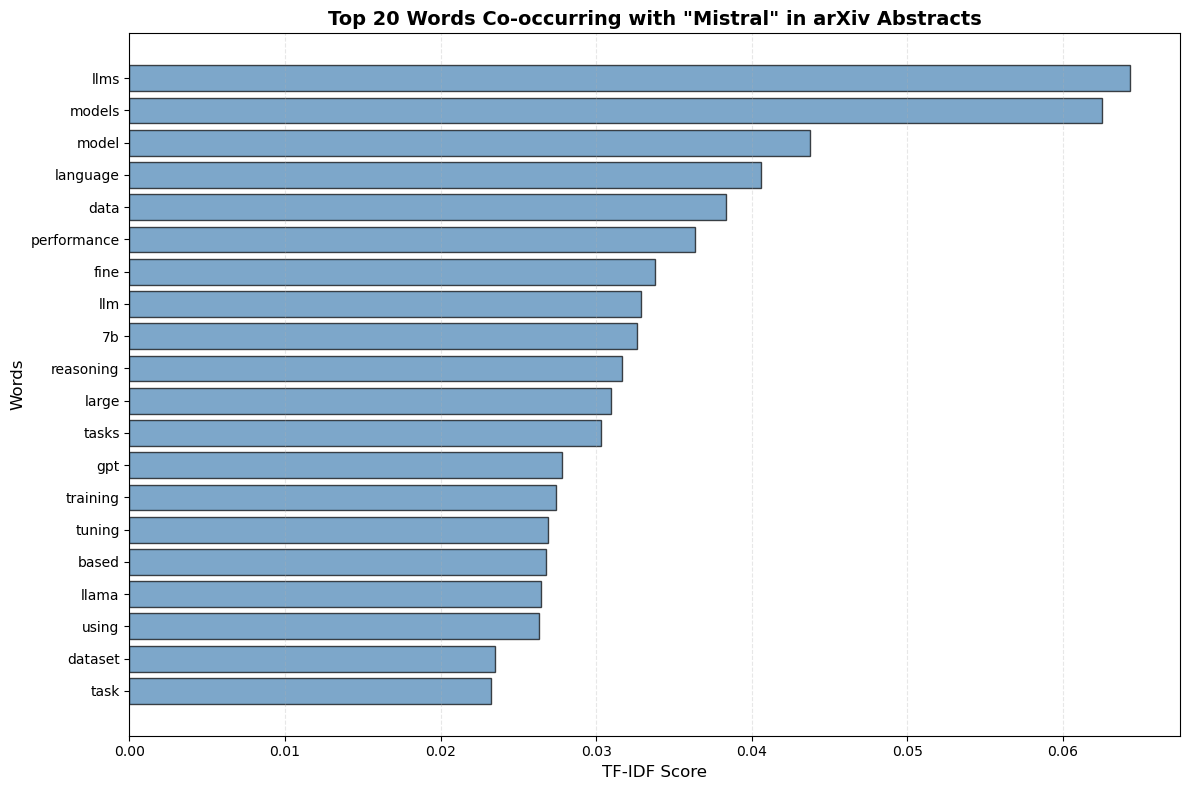

In [6]:
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Path to the dataset
file_path = 'arxiv-metadata-oai-snapshot.json'

# Collect abstracts containing "Mistral"
mistral_abstracts = []

# Read the file line by line
with open(file_path, 'r') as f:
    for line_num, line in enumerate(f, 1):
        try:
            article = json.loads(line)
            abstract = article.get('abstract', '')
            
            # Search for "Mistral" (case-insensitive)
            if 'mistral' in abstract.lower():
                mistral_abstracts.append(abstract)
        
        except json.JSONDecodeError:
            print(f"Error parsing line {line_num}")
            continue
        
        if line_num % 500000 == 0:
            print(f"Processed {line_num:,} articles... Found {len(mistral_abstracts)} with 'Mistral'")

print(f"\nTotal articles processed: {line_num:,}")
print(f"Articles containing 'Mistral': {len(mistral_abstracts)}")

# Analyze co-occurring words using TF-IDF
if mistral_abstracts:
    print("\nAnalyzing word co-occurrences with 'Mistral'...")
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        ngram_range=(1, 1),
        min_df=2
    )
    
    # Fit and transform the abstracts
    tfidf_matrix = vectorizer.fit_transform(mistral_abstracts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Calculate mean TF-IDF scores for each word
    mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top words (excluding 'mistral' itself)
    top_indices = mean_tfidf.argsort()[::-1]
    top_words = []
    top_scores = []
    
    for idx in top_indices:
        word = feature_names[idx]
        if word.lower() != 'mistral':
            top_words.append(word)
            top_scores.append(mean_tfidf[idx])
        if len(top_words) == 20:
            break
    
    # Print top co-occurring words
    print(f"\nTop 20 words co-occurring with 'Mistral' (by TF-IDF score):")
    print("="*60)
    for i, (word, score) in enumerate(zip(top_words, top_scores), 1):
        print(f"{i:2d}. {word:20s} (score: {score:.4f})")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_words)), top_scores, color='steelblue', edgecolor='black', alpha=0.7)
    plt.yticks(range(len(top_words)), top_words)
    plt.xlabel('TF-IDF Score', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.title('Top 20 Words Co-occurring with "Mistral" in arXiv Abstracts', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("\nFound nothing")

In [ ]:
import json

# Path to the dataset
file_path = 'arxiv-metadata-oai-snapshot.json'

# Collect abstract lengths
abstract_lengths = []
target_count = 10000

# Read the file line by line
with open(file_path, 'r') as f:
    for line in f:
        try:
            article = json.loads(line)
            abstract = article.get('abstract', '')
            
            if abstract:
                abstract_lengths.append(len(abstract))
            
            # Stop after collecting 1000 abstracts
            if len(abstract_lengths) == target_count:
                break
        
        except json.JSONDecodeError:
            continue

# Calculate average
if abstract_lengths:
    avg_length = sum(abstract_lengths) / len(abstract_lengths)
    print(f"Number of abstracts analyzed: {len(abstract_lengths)}")
    print(f"Average abstract length: {avg_length:.2f} characters")
    print(f"Minimum length: {min(abstract_lengths)} characters")
    print(f"Maximum length: {max(abstract_lengths)} characters")

Number of abstracts analyzed: 10000
Average abstract length: 800.40 characters
Minimum length: 20 characters
Maximum length: 1875 characters


Processed 500,000 articles...
Processed 1,000,000 articles...
Processed 1,500,000 articles...
Processed 2,000,000 articles...
Processed 2,500,000 articles...

Total articles processed: 2,854,539
Number of categories found: 174

Top 20 subject areas with longest abstracts:
 1. astro-ph.GA          - 1438.50 chars (n=51,696)
 2. astro-ph.EP          - 1396.64 chars (n=24,908)
 3. physics.med-ph       - 1348.74 chars (n=5,520)
 4. astro-ph.SR          - 1338.09 chars (n=46,314)
 5. eess.IV              - 1301.09 chars (n=18,211)
 6. astro-ph.CO          - 1291.16 chars (n=43,072)
 7. q-bio.TO             - 1277.31 chars (n=1,272)
 8. q-bio.NC             - 1268.82 chars (n=7,047)
 9. cs.CV                - 1266.16 chars (n=130,498)
10. astro-ph.HE          - 1265.05 chars (n=43,571)
11. q-bio.QM             - 1263.05 chars (n=5,707)
12. physics.geo-ph       - 1257.36 chars (n=4,435)
13. physics.space-ph     - 1246.54 chars (n=2,402)
14. cs.AR                - 1245.44 chars (n=4,248)
15. c

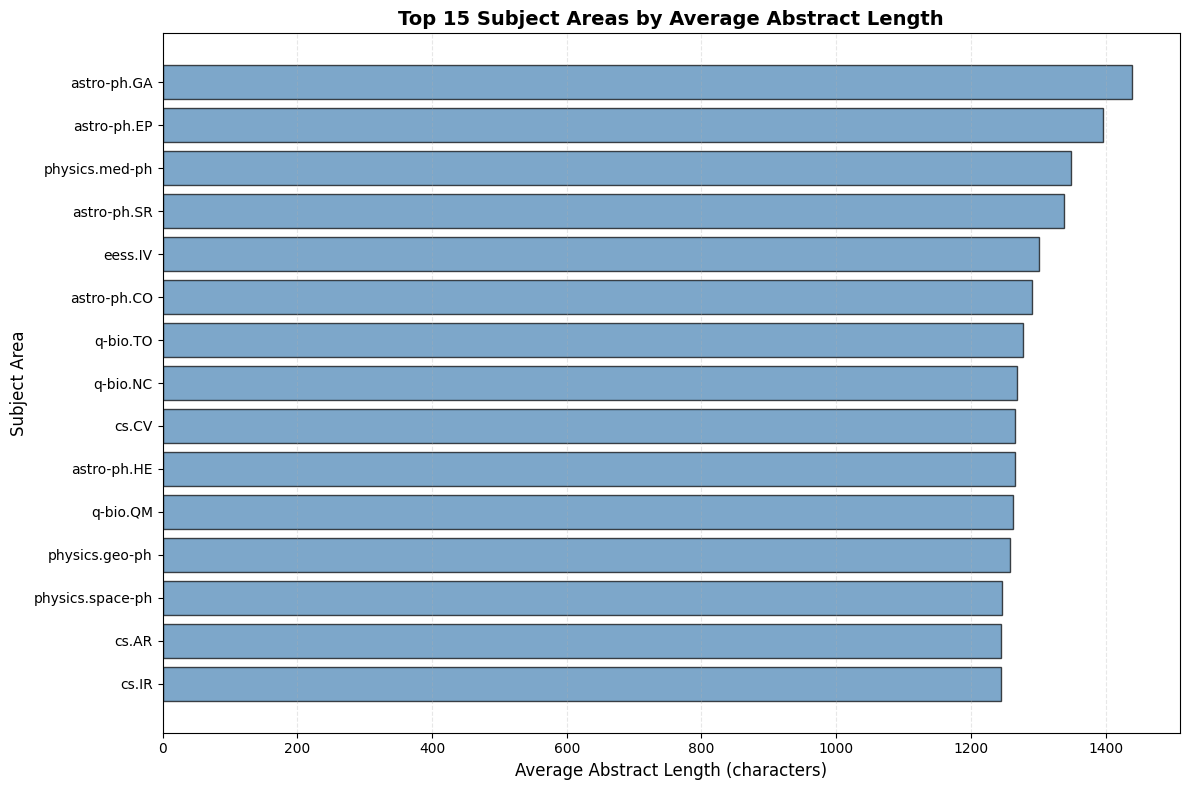

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

# Path to the dataset
file_path = 'arxiv-metadata-oai-snapshot.json'

# Dictionary to store lengths by category
category_lengths = defaultdict(list)

# Read the file line by line
with open(file_path, 'r') as f:
    for line_num, line in enumerate(f, 1):
        try:
            article = json.loads(line)
            abstract = article.get('abstract', '')
            categories = article.get('categories', '')
            
            if abstract and categories:
                # Get the primary category (first one listed)
                primary_category = categories.split()[0]
                category_lengths[primary_category].append(len(abstract))
        
        except json.JSONDecodeError:
            continue
        
        if line_num % 500000 == 0:
            print(f"Processed {line_num:,} articles...")

print(f"\nTotal articles processed: {line_num:,}")
print(f"Number of categories found: {len(category_lengths)}")

# Calculate average length per category
category_averages = {}
for category, lengths in category_lengths.items():
    if len(lengths) >= 10:  # Only include categories with at least 10 articles
        category_averages[category] = sum(lengths) / len(lengths)

# Sort by average length
sorted_categories = sorted(category_averages.items(), key=lambda x: x[1], reverse=True)

# Print top 20 categories with longest abstracts
print(f"\nTop 20 subject areas with longest abstracts:")
print("="*70)
for i, (category, avg_length) in enumerate(sorted_categories[:20], 1):
    article_count = len(category_lengths[category])
    print(f"{i:2d}. {category:20s} - {avg_length:7.2f} chars (n={article_count:,})")

# Create visualization for top 15
top_15 = sorted_categories[:15]
categories = [cat for cat, _ in top_15]
averages = [avg for _, avg in top_15]

plt.figure(figsize=(12, 8))
plt.barh(range(len(categories)), averages, color='steelblue', edgecolor='black', alpha=0.7)
plt.yticks(range(len(categories)), categories)
plt.xlabel('Average Abstract Length (characters)', fontsize=12)
plt.ylabel('Subject Area', fontsize=12)
plt.title('Top 15 Subject Areas by Average Abstract Length', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()